# 0. Install Dependencies and Bring in Data

In [2]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [3]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [4]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 1. Preprocess

In [6]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      1.3.0
aiohttp                      3.8.3
aiosignal                    1.3.1
anyio                        3.6.2
argcomplete                  1.12.3
argon2-cffi                  20.1.0
astunparse                   1.6.3
async-generator              1.10
async-timeout                4.0.2
asynctest                    0.13.0
attrs                        21.4.0
backcall                     0.2.0
bcrypt                       4.0.1
beautifulsoup4               4.11.1
bleach                       4.1.0
bpemb                        0.3.4
cachetools                   5.2.0
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.12
chart-studio                 1.1.0
click                        8.1.3
cloudpickle                  2.0.0
colorama                     0.4.4
conllu                       4.5.2
cryptography                 38.0.4
c

In [7]:
from tensorflow.keras.layers import TextVectorization

In [8]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 200000 # number of words in the vocab

In [10]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# 2. Create Sequential Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [16]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [19]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 1810s 258ms/step - loss: 0.0626 - val_loss: 0.0461


In [20]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

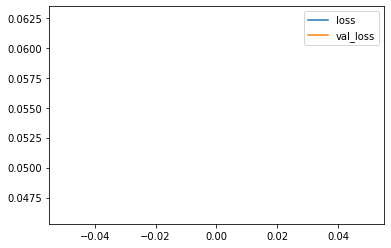

In [21]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [22]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [23]:
res = model.predict(np.array([input_text]))

In [24]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [25]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [26]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0]])

In [27]:
res.shape

(1, 6)

In [28]:
res

array([[0.98743004, 0.19382653, 0.89984995, 0.04787036, 0.74728346,
        0.16299686]], dtype=float32)

# 4. Evaluate Model

In [29]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [32]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.7706948518753052, Recall:0.7430818676948547, Accuracy:0.46840521693229675


# 5. Testing

In [33]:
model.save('toxicity.h5')

In [34]:
model = tf.keras.models.load_model('toxicity.h5')

In [35]:
comment = 'hey i freaken hate you!'
input_str = vectorizer('hey i freaken hate you!')

In [36]:
results = model.predict(np.array([input_str]))

In [37]:
results

array([[0.89291465, 0.03975529, 0.5803042 , 0.0437987 , 0.52402616,
        0.09300096]], dtype=float32)

In [38]:
text = ''
for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)

print(text)

toxic: True
severe_toxic: False
obscene: True
threat: False
insult: True
identity_hate: False



# 6. User Interface

In [39]:
!pip install gradio jinja2

In [40]:
import tensorflow as tf
import gradio as gr

In [41]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [42]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

J:\Program Files\Anaconda3\envs\python37\lib\site-packages\gradio\inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
J:\Program Files\Anaconda3\envs\python37\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [43]:
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://c4573352d233328e.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
